<a href="https://colab.research.google.com/github/Olga225/ITMO_Statistics_and_ML/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_5_1_(Logreg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [32]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [33]:
class MyBinaryLogisticRegression:
    def __init__(self, regularization=None, weight_calc='gd', lambda_1=None, lambda_2=None, batch_size=100):
      if regularization not in [None, 'l1', 'l2', 'l1l2']:
          raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
      if weight_calc not in ['nt', 'gd', 'sgd']:
          raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
      if regularization in ['l1', 'l1l2'] and lambda_1 is None:
        raise TypeError(f"Значение коэффициента регулризации l1 не задано")
      if regularization in ['l2', 'l1l2'] and lambda_2 is None:
        raise TypeError(f"Значение коэффициента регулризации l2 не задано")
      if regularization in ['l1', 'l1l2'] and weight_calc == 'nt':
        raise TypeError(f"Нельзя использовать weight_calc = nt с заданным параметром regularization.")


      self.regularization = regularization
      self.weight_calc = weight_calc
      self.lambda_1 = lambda_1
      self.lambda_2 = lambda_2
      self.batch_size = batch_size
      self.coefs_ = None
      self.intercept_ = None
      self.feature_names_in_ = None

    def print_parameters(self):
      print("Регуляризация:", self.regularization)
      print("Метод вычисления:", self.weight_calc)
      print("Lambda 1:", self.lambda_1)
      print("Lambda 2:", self.lambda_2)
      print("Batch size:", self.batch_size)

      return None

    """
    ГРАДИЕНТ И СИГМОИДА
    """
    def get_sigmoid(self, X,W):
      wx = X @ W
      return 1/ (1 + np.exp(-wx))

    def get_target(self, X,Y,W):
      sig = self.get_sigmoid(X, W)
      return np.sum(Y * np.log(sig) + (1 - Y) * np.log(1 - sig))

    def get_grad(self, X,Y,W):
      grad = (Y -self.get_sigmoid(X, W)) @ X

      if self.regularization == 'l1':
        grad_l1 = self.lambda_1 * np.sign(W)
        grad_l1[0] = 0
        grad = grad - grad_l1
      if self.regularization == 'l2':
        grad_l2 = 2 * self.lambda_2 * W
        grad_l2[0] = 0
        grad = grad - grad_l2
      if self.regularization == 'l1l2':
        grad_l1 = self.lambda_1 * np.sign(W)
        grad_l1[0] = 0
        grad_l2 = 2 * self.lambda_2 * W
        grad_l2[0] = 0
        grad = grad - grad_l1 - grad_l2

      return grad


    """
    ГЕССИАН
    """
    def get_hess_inv(self, X,W):
      sigm = self.get_sigmoid(X,W)
      matr = sigm.T * (1 - sigm)
      hes = X.T @ np.diag(matr) @ X

      if self.regularization == 'l2':
        hes_l2 = 2 * self.lambda_2 * np.eye(X.shape[1])
        hes_l2[0] = 0
        hes = hes + hes_l2

      hes = hes + 0.001 * np.eye(hes.shape[0])
      hes_inv = -np.linalg.inv(hes)
      return hes_inv

    """
    МЕТОД НЬЮТОНА
    """
    def NT_fit(self, X: np.array, Y: np.array, W: np.array):
      n_iter_nt = 2000

      for i in range (0, n_iter_nt):
        xes = self.get_hess_inv(X, W)
        grad = self.get_grad(X,Y,W)
        W = W - xes @ grad

      return W

    """
    ГРАДИЕНТНЫЙ СПУСК
    """

    def GD_fit(self, X: np.array, Y: np.array, W: np.array):
      n_iter = 50000
      alpha = 0.01
      early_stopping=0.0001

      for i in range (0, n_iter):
        grad = self.get_grad(X,Y,W)
        if np.linalg.norm(grad) < early_stopping:
          break
        W = W + alpha * grad


      return W

    """
    СТОХАСТИЧЕСКИЙ ГРАДИЕНТНЫЙ СПУСК
    """

    def SGD_fit(self, X: np.array, Y: np.array, W: np.array):
      alpha=0.01
      max_iter=50000
      early_stopping=0.0001

      for i in range(max_iter):
        inds = np.random.permutation(X.shape[0])
        X_shuffled = X[inds]
        Y_shuffled = Y[inds]

        for b in range(0, X_shuffled.shape[0], self.batch_size):
          X_batch = X_shuffled[b:b+self.batch_size]
          Y_batch = Y_shuffled[b:b+self.batch_size]

          grad = self.get_grad(X_batch, Y_batch, W)
          W = W + alpha * grad

        if np.linalg.norm(grad) < early_stopping:
          break

      return W


    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        #X = X.to_numpy()
        Y = y.to_numpy().reshape(-1)
        X_with_ones = np.c_[np.ones(X.shape[0]), X]
        W = np.random.uniform(size = X_with_ones.shape[1])

        # Метод Ньютона
        if self.weight_calc == 'nt':
          coef_results = self.NT_fit(X_with_ones, Y, W)

        # Градиентный спуск
        if self.weight_calc == 'gd':
          coef_results = self.GD_fit(X_with_ones, Y, W)

        # Стохастический градиентный спуск
        if self.weight_calc == 'sgd':
          coef_results = self.SGD_fit(X_with_ones, Y, W)

        self.intercept_ = coef_results[0]
        self.coefs_ = coef_results[1:]

    def predict(self, X: np.array):
      if self.coefs_ is None or self.intercept_ is None:
        raise Exception("Модель не обучена")

      y_pred = X @ self.coefs_ + self.intercept_
      y_pred_sigmoid = 1 / (1 + np.exp(-y_pred))

      predictions = np.array([0 if y < 0.5 else 1 for y in y_pred_sigmoid])

      return predictions

    def score(self, X: np.array, y: np.array):
      y_pred = self.predict(X)

      true_positive = np.sum((y == 1) & (y_pred == 1))
      false_positive = np.sum((y == 0) & (y_pred == 1))
      false_negative = np.sum((y == 1) & (y_pred == 0))

      f1_score = 2 * true_positive / (2 * true_positive + false_positive + false_negative)

      return f1_score

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [34]:
df = pd.read_csv('penguins_binary_classification.csv')

# Преобразуем названия двух видов пингвинов к классам 1/0 ('Adelie' / 'Gentoo')
df['species'] = df['species'].apply(lambda x: 1 if x == 'Adelie' else 0)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('species', axis = 1), df['species'], test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis = 1)

# Target Encoder для island
encoding_map = df_train.groupby('island')['species'].mean()
overall_mean = df_train['species'].mean()

train_encoded = df_train.copy()
train_encoded['island'] = train_encoded['island'].map(encoding_map)

X_test_encoded = X_test.copy()
X_test_encoded['island'] = X_test_encoded['island'].map(encoding_map)
X_test_encoded['island'] = X_test_encoded['island'].fillna(overall_mean)

# One-Hot для island
encoder = OneHotEncoder(sparse_output=False, drop='first')

one_hot_encoded = encoder.fit_transform(df_train[['island']])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['island']), index=df_train.index)
df_train_onehot = pd.concat([df_train.drop('island', axis=1), one_hot_df], axis=1)

one_hot_encoded_test = encoder.transform(X_test[['island']])
one_hot_df_test = pd.DataFrame(one_hot_encoded_test, columns=encoder.get_feature_names_out(['island']), index=X_test.index)
X_test_onehot = pd.concat([X_test.drop('island', axis=1), one_hot_df_test], axis=1)

# Разделение X и y
X_train_encoded = train_encoded.drop('species', axis=1)
X_train_onehot = df_train_onehot.drop('species', axis=1)

# Скалирование
scaler = MinMaxScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

scaler = MinMaxScaler()
X_train_onehot = scaler.fit_transform(X_train_onehot)
X_test_onehot = scaler.transform(X_test_onehot)

In [35]:
def My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_onehot_train, X_onehot_test):
  my_reg.fit(X_train_encoded, y_train)
  y_pred = my_reg.predict(X_test_encoded)
  score = my_reg.score(X_test_encoded, y_test)
  print("Для Target Encoder: f1-score = ", score)

  my_reg.fit(X_onehot_train, y_train)
  y_pred = my_reg.predict(X_onehot_test)
  score = my_reg.score(X_onehot_test, y_test)
  print("Для One-Hot Encoder: f1-score = ", score)

  return None

In [36]:
""" Самостоятельная реализация """
print("Класс MyBinaryLogisticRegression\n\n")

# Метод Ньютона
print("---- Метод Ньютона ----")

print("-- Без регуляризации")
my_reg = MyBinaryLogisticRegression(weight_calc='nt')
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

print("-- Регуляризация Ridge")
my_reg = MyBinaryLogisticRegression(weight_calc='nt', regularization = 'l2', lambda_2 = 10)
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

# Градиентный спуск
print("\n---- Градиентный спуск ----")

print("-- Без регуляризации")
my_reg = MyBinaryLogisticRegression(weight_calc='gd')
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

print("-- Регуляризация Lasso")
my_reg = MyBinaryLogisticRegression(weight_calc='gd', regularization = 'l1', lambda_1 = 10)
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

print("-- Регуляризация Ridge")
my_reg = MyBinaryLogisticRegression(weight_calc='gd', regularization = 'l2', lambda_2 = 10)
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

# Стохастический градиентный спуск
print("\n---- Стохастический градиентный спуск ----")

print("-- Без регуляризации")
my_reg = MyBinaryLogisticRegression(weight_calc='sgd')
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

print("-- Регуляризация Lasso")
my_reg = MyBinaryLogisticRegression(weight_calc='sgd', regularization = 'l1', lambda_1 = 10)
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

print("-- Регуляризация Ridge")
my_reg = MyBinaryLogisticRegression(weight_calc='sgd', regularization = 'l2', lambda_2 = 10)
My_log_regression_call(my_reg, X_train_encoded, y_train, X_test_encoded, y_test, X_train_onehot, X_test_onehot)

""" Библиотечная реализация """
print("\n\nБиблиотечная реализация\n\n")

clf = LogisticRegression(random_state=0).fit(X_train_encoded, y_train)
score = clf.score(X_test_encoded, y_test)
print("Для Target Encoder: f1-score = ", score)

clf = LogisticRegression(random_state=0).fit(X_train_onehot, y_train)
score = clf.score(X_test_onehot, y_test)
print("Для One-Hot Encoder: f1-score = ", score)

Класс MyBinaryLogisticRegression


---- Метод Ньютона ----
-- Без регуляризации
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0
-- Регуляризация Ridge
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0

---- Градиентный спуск ----
-- Без регуляризации
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0
-- Регуляризация Lasso
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0
-- Регуляризация Ridge
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0

---- Стохастический градиентный спуск ----
-- Без регуляризации
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  1.0
-- Регуляризация Lasso
Для Target Encoder: f1-score =  0.8461538461538461
Для One-Hot Encoder: f1-score =  0.7058823529411765
-- Регуляризация Ridge
Для Target Encoder: f1-score =  1.0
Для One-Hot Encoder: f1-score =  0.9836065573770492


Библиотечная реализация


Для Target Encoder: f1-score =  1

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

Функция потерь:

$$
LogP(D|\omega) = \sum^N_{i=1}\sum^M_{j=1}y_{ij}LogP(C_j|x_i) = \sum^N_{i=1}\sum^M_{j=1}y_{ij}Log\frac{\exp(\omega_j^Tx_i)}{\sum_k \exp(\omega_k^Tx_i)} = \sum^N_{i=1}\sum^M_{j=1}y_{ij}(\omega_j^Tx_i - Log\sum_k \exp(\omega_k^Tx_i))
$$

Градиент:

$$
\frac{\partial{LogP(D|\omega)}}{\partial \omega_s} = \frac{\partial{\sum^N_{i=1}\sum^M_{j=1}y_{ij}(\omega_j^Tx_i - Log\sum_k \exp(\omega_k^Tx_i))}}{\partial \omega_s} = \frac{\partial{\sum^N_{i=1}\sum^M_{j=1}y_{ij}(\omega_j^Tx_i)}} {\partial \omega_s} - \frac{\partial{\sum^N_{i=1}\sum^M_{j=1}y_{ij}(Log\sum_k \exp(\omega_k^Tx_i))}}{\partial \omega_s} =
$$
$$
= \sum^N_{i=1}\sum^M_{j=1}y_{ij}(\delta_{js} x_i - \frac{\exp(w_s^Tx_i)}{\sum_k \exp(\omega_k^Tx_i)}) = \sum^N_{i=1}x_i(y_{is} - P(C_s|x_i)\sum^M_{j=1}y_{ij}) = \sum^N_{i=1}x_i(y_{is} - P(C_s|x_i))
$$

Гессиан

$$
H = \frac{\partial{\sum^N_{i=1}x_i(y_{is} - P(C_s|x_i))}}{\partial{\omega_l}} =\sum^N_{i=1} \frac{\partial{P(C_s|x_i)}}{\partial{\omega_l}}x_i^T =  \sum^N_{i=1} \frac{\partial{\frac{\exp(w_s^Tx_i)}{\sum_k \exp(\omega_k^Tx_i)}}}{\partial{\omega_l}}x_i^T
$$

$$
\frac{\partial{\frac{\exp(w_s^Tx_i)}{\sum_k \exp(\omega_k^Tx_i)}}}{\partial{\omega_l}} = [s = l] = \frac{\exp(w_s^Tx_i) x_i \sum_k \exp(\omega_k^Tx_i) - \exp(w_s^Tx_i) \exp(w_s^Tx_i) x_i}{(\sum_k \exp(\omega_k^Tx_i))^2} = x_iP(C_s|x_i)(1 - P(C_s|x_i))
$$

$$
\frac{\partial{\frac{\exp(w_s^Tx_i)}{\sum_k \exp(\omega_k^Tx_i)}}}{\partial{\omega_l}} = [s \neq l] = \frac{\exp(w_s^Tx_i)\exp(w_l^Tx_i)x_i}{(\sum_k \exp(\omega_k^Tx_i))^2} = x_iP(C_s|x_i)(-P(C_l|x_i))
$$

Тогда,

$$
H = \sum^N_{i=1} x_iP(C_s|x_i)(\delta_{sl} - P(C_l|x_i))x_i^T = \sum^N_{i=1} P(C_s|x_i)(\delta_{sl} - P(C_l|x_i))x_ix_i^T
$$

In [37]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


In [38]:
random_seed = 42
n_samples = 60

np.random.seed(random_seed)
X_1 = np.random.randn(n_samples // 3, 2) + [2, 2]
X_2 = np.random.randn(n_samples // 3, 2) - [2, 2]
X_3 = np.random.randn(n_samples // 3, 2) + [-1.5, 5]
X = np.vstack((X_1, X_2, X_3))
y = np.hstack((0 * np.ones(n_samples // 3), 1 * np.ones(n_samples // 3), 2 * np.ones(n_samples // 3)))

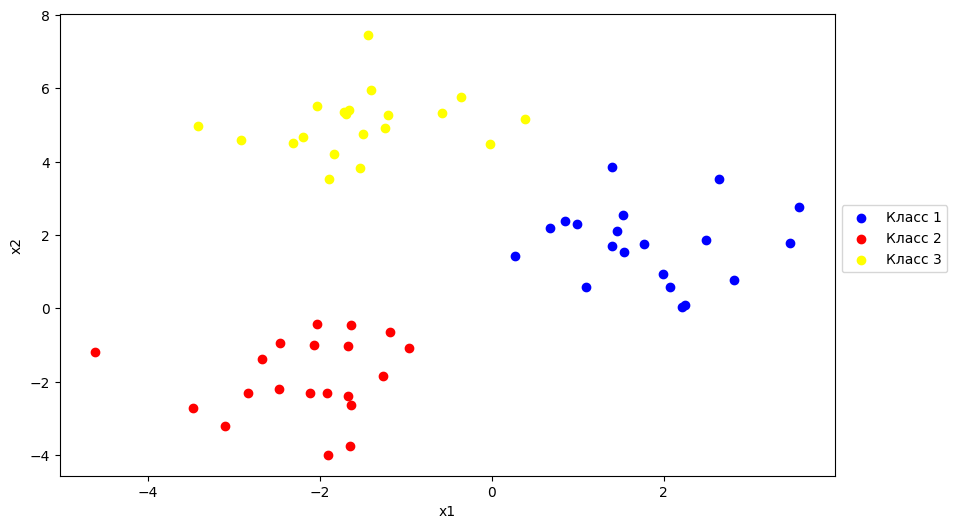

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Класс 1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Класс 2')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='yellow', label='Класс 3')

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(bbox_to_anchor=(1, 0.6), loc="upper left")
plt.show()

In [40]:
def find_P(X, W):
  xw = X @ W
  exp_xw = np.exp(xw - np.max(xw, axis=1, keepdims=True))
  return exp_xw / np.sum(exp_xw, axis=1, keepdims=True)


In [41]:
def get_gradient(X, Y, P):
  return X.T @ (P - Y)

In [42]:
def get_hessian(X, P):

  n_samples, n_features = X.shape
  n_classes = P.shape[1]

  hes = np.zeros((n_features * n_classes, n_features * n_classes))

  for s in range(n_classes):
    for l in range(n_classes):
      n_samples, n_features = X.shape

      if s == l:
        diag = P[:, s] * (1 - P[:, l])
      else:
        diag = -P[:, s] * P[:, l]

      D = np.diag(diag)
      H_block = X.T @ D @ X

      start_row = s * n_features
      end_row = (s+1) * n_features
      start_col = l * n_features
      end_col = (l+1) * n_features

      hes[start_row:end_row, start_col:end_col] = H_block


  return hes

In [43]:
def Newton_fit(X, Y, W):
  target_values_nt = []
  n_iter_nt = 200

  for i in range (0, n_iter_nt):
    P = find_P(X, W)
    grad = get_gradient(X, Y, P)
    H = get_hessian(X, P)
    grad_vec = grad.flatten('F')

    delta_vec = np.linalg.solve(H, -grad_vec)

    delta_W = delta_vec.reshape((n_features, n_classes), order='F')
    W += delta_W

    grad_norm = np.linalg.norm(grad_vec)
    if grad_norm < 1e-6:
      break

  return W



In [44]:
X_with_ones =  np.c_[np.ones(X.shape[0]), X]

enc = OneHotEncoder()
Y = pd.get_dummies(y).to_numpy()

n_samples, n_features = X_with_ones.shape
n_classes = Y.shape[1]

W = np.random.uniform(size = (n_features, n_classes))
W_new = Newton_fit(X_with_ones, Y, W)
print(W_new)

[[  2.77682621  -0.17211555 -24.03426151]
 [  8.37680574  -4.98865564 -10.9305993 ]
 [ -9.19461629 -16.90178011   0.60884934]]


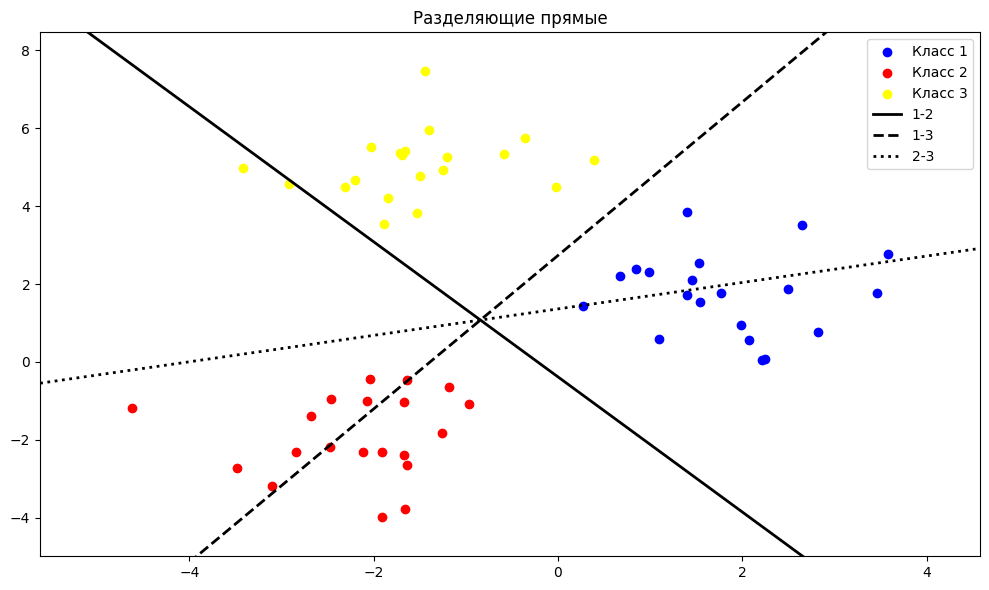

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Класс 1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Класс 2')
plt.scatter(X[y == 2, 0], X[y == 2, 1], color='yellow', label='Класс 3')

x_vals = np.array([X[:, 0].min() - 1, X[:, 0].max() + 1])

w01 = W_new[:, 0] - W_new[:, 1]
y01 = -(w01[0] + w01[1] * x_vals) / w01[2]
plt.plot(x_vals, y01, 'k-', linewidth=2, label='1-2')

w02 = W_new[:, 0] - W_new[:, 2]
y02 = -(w02[0] + w02[1] * x_vals) / w02[2]
plt.plot(x_vals, y02, 'k--', linewidth=2, label='1-3')

w12 = W_new[:, 1] - W_new[:, 2]
y12 = -(w12[0] + w12[1] * x_vals) / w12[2]
plt.plot(x_vals, y12, 'k:', linewidth=2, label='2-3')

plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
plt.title('Разделяющие прямые')
plt.legend()
plt.tight_layout()
plt.show()